In [1]:
import pandas as pd
import numpy as np
import pymssql 
import requests as re
import json
import geopandas as gpd
from shapely import geometry
from matplotlib import pyplot as plt
import os

In [2]:
import igraph as ig

In [3]:
import construct_networkx_fun as cnf
import networkx as nx
mmbsG=cnf.creat_networkx()

True
True


In [4]:
# 公交站点
df3=pd.read_csv('data\bus_station.csv',encoding='gbk')
df3=df3.drop(columns='Unnamed: 0')
def split_x22(x):
    return x+'_b'
df3['station']=df3['station'].apply(lambda x:split_x22(x))

# 地铁站点
df4=pd.read_csv('data\metro_station.csv',encoding='gbk')
df4=df4.drop(columns='Unnamed: 0')
def split_x32(x):
    return x+'_m'
df4['station']=df4['station'].apply(lambda x:split_x32(x))

df5=pd.concat([df3,df4])
print(df5.shape)
gemmbs = gpd.GeoDataFrame(df5[['station','lng','lat']],geometry=gpd.points_from_xy(df5['lng'],df5['lat']),crs='epsg:4326')

(7466, 4)


In [5]:
subs=pd.read_csv('resuls of subnetwork classification in BRTN.csv',encoding='gbk')

In [6]:
# 子网络的个数
subs.groupby(['modularity_class','label']).count()[['station']].shape

(2093, 1)

In [7]:
import glob

In [8]:
# 读取计算结果
# 读入文件
os.getcwd()
os.chdir(r'data\sub_resilience')
files=glob.glob('*.txt')
all_lt=[]
for i in files:
    fi=open(i)
    data=fi.readlines()
    da1=data[0].replace('[','').replace(']','').replace(' ','').replace("'",'').replace('nan','-1').replace('inf','-1').split(',')
    all_lt.append(da1)
    fi.close()
os.chdir(r'data\data_soure')
rsub=pd.DataFrame(all_lt)
# , , , 
rsub.columns=['l1','l2','expR_ICD','cosR_ICD','expR_FOD','cosR_FOD']
def int_x(x):
    return int(x)
def float_x(x):
    return float(x)
rsub['l1']=rsub['l1'].apply(lambda x:int_x(x))
rsub['l2']=rsub['l2'].apply(lambda x:int_x(x))
rsub['expR_ICD']=rsub['expR_ICD'].apply(lambda x:float_x(x))
rsub['cosR_ICD']=rsub['cosR_ICD'].apply(lambda x:float_x(x))
rsub['expR_FOD']=rsub['expR_FOD'].apply(lambda x:float_x(x))
rsub['cosR_FOD']=rsub['cosR_FOD'].apply(lambda x:float_x(x))
rsub.head()

,l1,l2,expR_ICD,cosR_ICD,expR_FOD,cosR_FOD
0,0,0,1.189249e+09,1.189520e+09,118.979062,169.510661
1,0,1,1.486955e+08,1.486971e+08,14.869869,21.181041
2,0,10,1.085247e+09,1.085328e+09,108.540693,154.617594
3,0,100,3.864117e+08,3.864612e+08,38.651175,55.061546
4,0,101,3.234381e+07,3.234670e+07,3.234960,4.608296


In [9]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [10]:

reduced_X=rsub[['expR_FOD']].values
reduced_X=[np.array(reduced_X[c]) for c in range(reduced_X.shape[0])]
reduced_X=np.array(reduced_X)

In [11]:
# K=5
clusterer = KMeans(n_clusters=5, random_state=10)
cluster_labels = clusterer.fit_predict(reduced_X)
rsub['clable']=cluster_labels
rsub1=rsub.copy()
rsub1=rsub1.rename(columns={'l1':'modularity_class','l2':'label'})
rr=rsub1.sort_values('expR_FOD',ascending=False)
lr=list(rr['clable'])
lr1=list(set(list(rr['clable'])))
lr1.sort(key=lr.index)
lr1

C:\ProgramData\Anaconda3\envs\py39\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


[2, 4, 1, 3, 0]

In [12]:
# sort the classification results
xs=lr1

zsxs=[]
for i in range(rsub1.shape[0]):
    if rsub1.iloc[i,6]==0:
        zsxs.append(0)
    if rsub1.iloc[i,6]==1:
        zsxs.append(2)
    if rsub1.iloc[i,6]==2:
        zsxs.append(4)
    if rsub1.iloc[i,6]==3:
        zsxs.append(1)
    if rsub1.iloc[i,6]==4:
        zsxs.append(3)
rsub1['clable']=zsxs
rsub1.head()

,modularity_class,label,expR_ICD,cosR_ICD,expR_FOD,cosR_FOD,clable
0,0,0,1.189249e+09,1.189520e+09,118.979062,169.510661,0
1,0,1,1.486955e+08,1.486971e+08,14.869869,21.181041,0
2,0,10,1.085247e+09,1.085328e+09,108.540693,154.617594,0
3,0,100,3.864117e+08,3.864612e+08,38.651175,55.061546,0
4,0,101,3.234381e+07,3.234670e+07,3.234960,4.608296,0


In [13]:

subs1=subs.merge(rsub1,on=['modularity_class','label'],how='outer')
subs2=subs1[-(subs1['clable']>=0)]
subs2=subs2.reset_index()
subs2=subs2.drop(columns=['level_0'])

subs20=subs2[['label','modularity_class']]
print(subs20.shape)
subs20=subs20.drop_duplicates()
print(subs20.shape)
subs20=subs20.reset_index()
subs20=subs20.drop(columns='index')

subs3=subs1.groupby(['modularity_class','label','clable']).count()[['station']]
subs3=subs3.reset_index()
ccl=[]
for i in range(subs20.shape[0]):
    mi=subs20.iloc[i,1]
    li=subs20.iloc[i,0]
    if subs3[subs3['modularity_class']==mi].shape[0]!=0:
        sbi3=subs3[subs3['modularity_class']==mi]
        ccl.append(int(sbi3.sort_values('station',ascending=False)['clable'].to_list()[0]))
    else:
        ccl.append(-1)
subs20['clable']=ccl

print(subs2.shape)
subs3=subs2.merge(subs20,on=['modularity_class','label'],how='inner')
print(subs3.shape)

subs3=subs3[subs3['clable_y']>=0][['index','station','label','modularity_class','clable_y']]
subs3=subs3.rename(columns={'clable_y':'clable'})

nsubs=subs1[(subs1['clable']>=0)][['index','station','label','modularity_class','clable']]
nsubs1=pd.concat([nsubs,subs3])
nsubs1=nsubs1.reset_index()
nsubs1=nsubs1.drop(columns='level_0')


pj=[]
for i in range(nsubs1.shape[0]):
    pj.append(str(int(nsubs1.iloc[i,3]))+'-'+str(int(nsubs1.iloc[i,2])))
nsubs1['new_class']=pj
nsubs1.head()

(1208, 2)
(473, 2)
(1208, 9)
(1208, 10)


,index,station,label,modularity_class,clable,new_class
0,0,黄村火车站_b,0.0,0,0.0,0-0
1,5937,黄村火车站北_b,0.0,0,0.0,0-0
2,7024,站前环岛东_b,0.0,0,0.0,0-0
3,4598,黄村西大街_b,0.0,0,0.0,0-0
4,330,兴丰街南口_b,0.0,0,0.0,0-0


In [14]:
subgemmbs=gemmbs.copy()
subgemmbs1=subgemmbs.merge(nsubs1,on='station',how='inner')
subgemmbs2=subgemmbs1[['station','lng','lat','geometry','new_class','clable']]
subgemmbs2.groupby(['clable']).count()[['station']]

,station
clable,
0.0,5541
1.0,1352
2.0,261
3.0,102
4.0,15


In [15]:
def obtian_motif(ss1,nas,eds):
    egs=[]
    eid=[]
    segs=[]
    for i in range(len(set(list(ss1['new_class'])))):
        ss1_i=ss1[ss1['new_class']==list(set(list(ss1['new_class'])))[i]]
        ss1_i=ss1_i[['station']]
        # 得到子网
        subjj1=ss1_i.merge(nas,on='station',how='inner')
        subjj2=subjj1.copy()
        subjj2.columns=['station','edgi']
        subjj3=subjj2.merge(eds,on='edgi',how='inner')
        subjj4=subjj1.copy()
        subjj4.columns=['station','edgj']
        subjj5=subjj3.merge(subjj4,on=['edgj'],how='inner')
        subjj5=subjj5[['edgi','edgj']]
        # 创建子网
        lt_edgi=list(subjj5['edgi'])
        lt_edgj=list(subjj5['edgj'])
        nt_j=copy.deepcopy(lt_edgj)
        nt_j.extend(lt_edgi)

        dft=pd.DataFrame(list(set(nt_j)))
        dft.columns=['idi']
        dft=dft.reset_index()
        dft1=copy.deepcopy(dft)
        dft1.columns=['new_i','edgi']
        subjj6=subjj5.merge(dft1,on='edgi',how='inner')
        dft2=copy.deepcopy(dft)
        dft2.columns=['new_j','edgj']
        subjj7=subjj6.merge(dft2,on='edgj',how='inner')
        subjj7=subjj7[['edgi','edgj']]
        nas1=copy.deepcopy(nas)
        nas1=nas1.rename(columns={'ids':'edgi'})
        subjj8=subjj7.merge(nas1,on='edgi',how='inner')
        subjj8=subjj8.rename(columns={'station':'edg_i'})
        nas2=copy.deepcopy(nas)
        nas2=nas2.rename(columns={'ids':'edgj'})
        subjj9=subjj8.merge(nas2,on='edgj',how='inner')
        subjj9=subjj9.rename(columns={'station':'edg_j'})
        subjj9=subjj9[['edg_i','edg_j']]
        subjj9=subjj9.reset_index()
        subjj9=subjj9.drop(columns='index')
        bc=0
        mc=0
        mbc=0
        for j in range(subjj9.shape[0]):
            stj=subjj9.iloc[j,0]
            stj2=subjj9.iloc[j,1]
            if stj[-1]==stj2[-1] and stj[-1]=='b':
                bc=bc+1
            if stj[-1]==stj2[-1] and stj[-1]=='m':
                mc=mc+1
            if stj[-1]!=stj2[-1]:
                mbc=mbc+1
        egs.append([bc,mc,mbc])
        segs.append(str([bc,mc,mbc]))
        eid.append(list(set(list(ss1['new_class'])))[i])

    yilei=pd.DataFrame(egs)
    yilei.columns=['BTN','RTN','BRTN']
    yilei['id']=eid
    yilei['str']=segs

    cyi=yilei.groupby('str').count()[['BTN']]
    cyi=cyi.sort_values('BTN',ascending=False)
    cyi['p']=np.array(cyi['BTN'])/sum(np.array(cyi['BTN']))
    cyi=cyi.reset_index()
    cyi=cyi[['str','p']]
    cyi=cyi.head(10)
    cyi2=yilei.merge(cyi,on='str',how='inner')
    cyi2=cyi2.sort_values(by='p',ascending=False)
    cyi2=cyi2.drop_duplicates(subset=['str'])
    cyi2=cyi2[['str','p','id']]
    cyi2=cyi2.reset_index()
    cyi2=cyi2.drop(columns='index')
    cyi2=cyi2.rename(columns={'id':'rsub'})
    return cyi2

In [16]:
def obtain2(c1,ss1,nas,eds):
    egs=[]
    eid=[]
    segs=[]
    for i in range(len(set(list(ss1['new_class'])))):
        ss1_i=ss1[ss1['new_class']==list(set(list(ss1['new_class'])))[i]]
        ss1_i=ss1_i[['station']]
        # 得到子网
        subjj1=ss1_i.merge(nas,on='station',how='inner')
        subjj2=subjj1.copy()
        subjj2.columns=['station','edgi']
        subjj3=subjj2.merge(eds,on='edgi',how='inner')
        subjj4=subjj1.copy()
        subjj4.columns=['station','edgj']
        subjj5=subjj3.merge(subjj4,on=['edgj'],how='inner')
        subjj5=subjj5[['edgi','edgj']]
        # 创建子网
        lt_edgi=list(subjj5['edgi'])
        lt_edgj=list(subjj5['edgj'])
        nt_j=copy.deepcopy(lt_edgj)
        nt_j.extend(lt_edgi)

        dft=pd.DataFrame(list(set(nt_j)))
        dft.columns=['idi']
        dft=dft.reset_index()
        dft1=copy.deepcopy(dft)
        dft1.columns=['new_i','edgi']
        subjj6=subjj5.merge(dft1,on='edgi',how='inner')
        dft2=copy.deepcopy(dft)
        dft2.columns=['new_j','edgj']
        subjj7=subjj6.merge(dft2,on='edgj',how='inner')
        subjj7=subjj7[['edgi','edgj']]
        nas1=copy.deepcopy(nas)
        nas1=nas1.rename(columns={'ids':'edgi'})
        subjj8=subjj7.merge(nas1,on='edgi',how='inner')
        subjj8=subjj8.rename(columns={'station':'edg_i'})
        nas2=copy.deepcopy(nas)
        nas2=nas2.rename(columns={'ids':'edgj'})
        subjj9=subjj8.merge(nas2,on='edgj',how='inner')
        subjj9=subjj9.rename(columns={'station':'edg_j'})
        subjj9=subjj9[['edg_i','edg_j']]
        subjj9=subjj9.reset_index()
        subjj9=subjj9.drop(columns='index')
        bc=0
        mc=0
        mbc=0
        for j in range(subjj9.shape[0]):
            stj=subjj9.iloc[j,0]
            stj2=subjj9.iloc[j,1]
            if stj[-1]==stj2[-1] and stj[-1]=='b':
                bc=bc+1
            if stj[-1]==stj2[-1] and stj[-1]=='m':
                mc=mc+1
            if stj[-1]!=stj2[-1]:
                mbc=mbc+1
        egs.append([bc,mc,mbc])
        segs.append(str([bc,mc,mbc]))
        eid.append(list(set(list(ss1['new_class'])))[i])

    yilei=pd.DataFrame(egs)
    yilei.columns=['BTN','RTN','BRTN']
    yilei['id']=eid
    yilei['str']=segs
    c1=c1[['str']]
    c1['cc']=1
    c2=c1.merge(yilei,on='str',how='outer')
    yilei=c2[c2['cc']!=1]
    yilei=yilei.drop(columns=['cc'])
    yilei=yilei.reset_index()
    yilei=yilei.drop(columns='index')
    cyi=yilei.groupby('str').count()[['BTN']]
    cyi=cyi.sort_values('BTN',ascending=False)
    cyi['p']=np.array(cyi['BTN'])/sum(np.array(cyi['BTN']))
    cyi=cyi.reset_index()
    cyi=cyi[['str','p']]
    cyi=cyi.head(10)
    cyi2=yilei.merge(cyi,on='str',how='inner')
    cyi2=cyi2.sort_values(by='p',ascending=False)
    cyi2=cyi2.drop_duplicates(subset=['str'])
    cyi2=cyi2[['str','p','id']]
    cyi2=cyi2.reset_index()
    cyi2=cyi2.drop(columns='index')
    cyi2=cyi2.rename(columns={'id':'rsub'})
    return cyi2


In [17]:
# networkx 节点属性
nas=nx.get_node_attributes(mmbsG,'name')
nas=pd.DataFrame(nas.items())
nas.columns=['ids','station']
nas.head()

,ids,station
0,0,黄村火车站_b
1,5937,黄村火车站北_b
2,7024,站前环岛东_b
3,7271,义和庄_m
4,1,清华园_b


In [18]:
# netwkorkx 边属性
eds=nx.get_edge_attributes(mmbsG,'weight')
eds=pd.DataFrame(list(eds.keys()))
eds.columns=['edgi','edgj']
eds.head()

,edgi,edgj
0,0,5937
1,0,7024
2,0,7271
3,5937,2657
4,5937,4450


In [19]:
import copy

<AxesSubplot:>

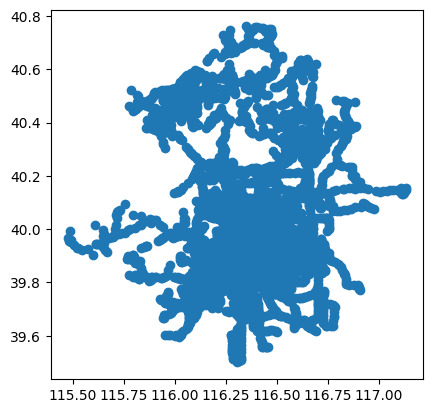

In [20]:
subgemmbs1.plot()

In [35]:
subgemmbs1.head()

,station,lng,lat,geometry,index,label,modularity_class,clable,new_class
0,霍营北口_b,116.36554,40.08844,POINT (116.36554 40.08844),3424,199.0,4,0.0,4-199
1,新苑街_b,116.32855,39.93540,POINT (116.32855 39.93540),6165,187.0,4,1.0,4-187
2,建功北里_b,116.35368,39.88061,POINT (116.35368 39.88061),3135,112.0,0,0.0,0-112
3,万盛北里_b,116.65084,39.86986,POINT (116.65084 39.86986),4524,93.0,7,0.0,7-93
4,莲怡园北路_b,116.29767,39.88671,POINT (116.29767 39.88671),41,15.0,6,0.0,6-15


In [55]:
subgemmbs1['sb']=subgemmbs1['station'].apply(lambda x:x[-1])


In [75]:
bs_line=gpd.read_file('shapefile\\bus_line.shp',encoding='utf-8')
ms_line=gpd.read_file('shapefile\\subway_line.shp',encoding='utf-8')
beij=gpd.read_file('shapefile\\beij_fq.shp',encoding='utf-8')

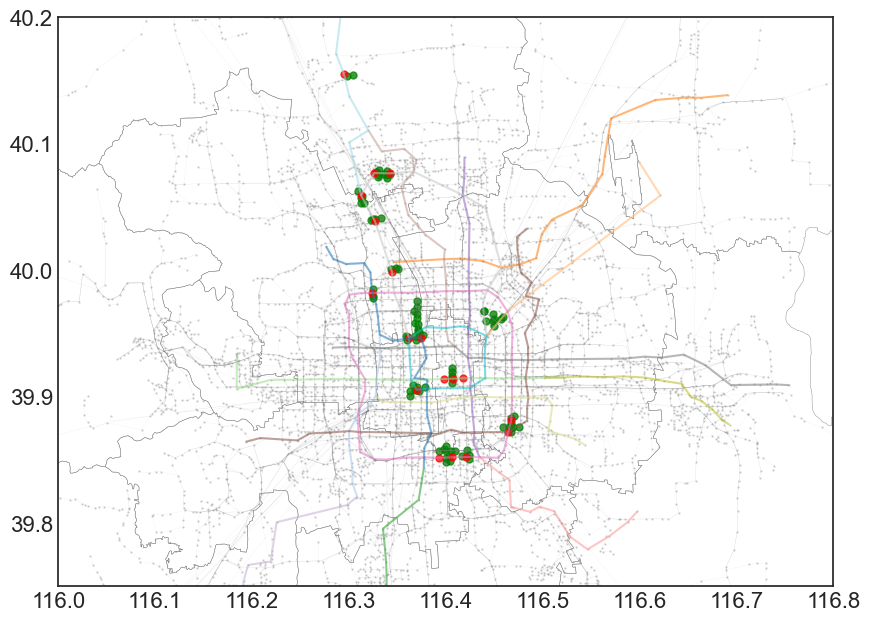

In [137]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.set_xlim(116.0,116.8)
ax.set_ylim(39.75,40.2)
#
beij.plot(ax=ax,facecolor='none',edgecolor='gray',linewidth=0.3)
bs_line.plot(ax=ax,linewidth=0.1,color='gray',alpha=0.3)
line_shp=ms_line
mmbslblen=line_shp.shape[0]
leg=['line 9','line 15','airport line','Daxing line','line 1','Yizhuang line','line 6','Fangsan line',
     'line 14','line 8','line 10','line 6','line 13','Batong line','line 7','line 2','Changping line','line 4']
mbmap_vir = plt.cm.get_cmap(name='tab20')
mbcolor =mbmap_vir(list(np.linspace(0,1,len(leg))))
for j in range(1,len(leg)):
    line_shp[j-1:j].plot(ax=ax,legend=True,label=leg[j-1],color=mbcolor[j],linewidth=1.5,alpha=0.56)
line_shp[j:j+1].plot(ax=ax,legend=True,label=leg[j],color=mbcolor[0],linewidth=1.5,alpha=0.56)

#
subgemmbs1[subgemmbs1['sb']=='b'].plot(ax=ax,markersize=0.5,color='gray',alpha=0.3)
subgemmbs1[subgemmbs1['sb']=='m'].plot(ax=ax,markersize=.5,color='gray',alpha=0.3)
#
lb4=subgemmbs1[subgemmbs1['clable']==4]
lb4[lb4['sb']=='b'].plot(ax=ax,markersize=25,color='green',alpha=0.75)
lb4[lb4['sb']=='m'].plot(ax=ax,markersize=25,color='red',alpha=0.75)
#
lb4=subgemmbs1[subgemmbs1['clable']==3]
lb4[lb4['sb']=='b'].plot(ax=ax,markersize=25,color='green',alpha=0.75)
lb4[lb4['sb']=='m'].plot(ax=ax,markersize=25,color='red',alpha=0.75)
ax.tick_params(labelsize=16)
fig.savefig(r'tu\fig_7.png', dpi=1200)